# Credit Card Fraud Detection Project

This notebook demonstrates a credit card fraud detection model using the provided dataset. The process includes data loading, preprocessing, model training, evaluation, and generating files for potential deployment.

In [ ]:
# ---------- Install necessary packages ----------
!pip install -q kaggle imbalanced-learn xgboost joblib shap matplotlib seaborn flask

## Data Loading

### Objective:
Load the credit card transaction data from Google Drive.

**Explanation**:
We will mount Google Drive to access the dataset stored in a specified folder. The dataset will be loaded into a pandas DataFrame for further processing.

In [ ]:
# ---------- Mount Google Drive ----------
from google.colab import drive
drive.mount('/content/drive')

# Define the target directory in Google Drive where the dataset is located
drive_output_dir = '/content/drive/MyDrive/Euphoria GenX Project (Credit Card Fraud Detection)'
import os # Import os here
os.makedirs(drive_output_dir, exist_ok=True) # Create the directory if it doesn't exist

# ---------- Load dataset from Google Drive ----------
import pandas as pd
path = os.path.join(drive_output_dir, 'creditcard.csv')
if not os.path.exists(path):
    raise FileNotFoundError("creditcard.csv not found at the specified Google Drive path. Make sure you have mounted your drive and the path is correct.")
df = pd.read_csv(path)
print("Loaded", df.shape, "rows")
display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded (284807, 31) rows


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Preprocessing and Splitting

### Objective:
Prepare the data for model training by handling missing values, scaling features, and splitting the data into training and testing sets. Address class imbalance using SMOTE.

**Explanation**:
We will perform the following preprocessing steps:
1. Drop rows with missing values in the 'Class' column.
2. Scale the 'Time' and 'Amount' features using StandardScaler.
3. Split the data into training and testing sets while maintaining the original class distribution (stratified split).
4. Apply SMOTE (Synthetic Minority Over-sampling Technique) to the training data to handle the class imbalance issue.

In [ ]:
# ---------- Preprocessing & split ----------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

# Drop rows with missing values in the 'Class' column
df.dropna(subset=['Class'], inplace=True)

X = df.drop('Class', axis=1)
y = df['Class']

scaler = StandardScaler()
X[['Time','Amount']] = scaler.fit_transform(X[['Time','Amount']])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Save demo stats for mapper
demo_feature_stats = {}
for col in [f'V{i}' for i in range(1,29)]:
    demo_feature_stats[col] = {'mean': X_train[col].mean(), 'std': X_train[col].std()}

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After resample:", np.bincount(y_train_res))

After resample: [227451 227451]


## Model Training

### Objective:
Train an XGBoost classifier on the preprocessed and resampled training data.

**Explanation**:
We will train an XGBoost model, which is a powerful gradient boosting algorithm. A short RandomizedSearchCV is used to find a good set of hyperparameters for the model, optimizing for ROC AUC.

In [ ]:
# ---------- Train XGBoost with a short RandomizedSearchCV ----------
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score

xgb = XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [100,200],
    'max_depth': [3,5,7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8,1.0],
    'colsample_bytree': [0.7,1.0],
    'reg_lambda': [1,5]
}

rs = RandomizedSearchCV(xgb, param_dist, n_iter=12, scoring='roc_auc', cv=3, random_state=42, verbose=1, n_jobs=1)
rs.fit(X_train_res, y_train_res)
best = rs.best_estimator_
print("Best params:", rs.best_params_)

p_test = best.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, p_test)
pr_auc = average_precision_score(y_test, p_test)
print(f"Test ROC AUC: {roc:.4f}, PR AUC: {pr_auc:.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Test ROC AUC: 0.9812, PR AUC: 0.8543


## Model Evaluation

### Objective:
Evaluate the performance of the trained model using various metrics and visualizations.

**Explanation**:
We will calculate and display key evaluation metrics including Accuracy, Precision, Recall, F1-score, and the Confusion Matrix. Additionally, we will generate ROC and Precision-Recall curves to visualize the model's performance, especially considering the imbalanced nature of the dataset.

### Calculate Evaluation Metrics

**Reasoning**:
Import the necessary metrics from sklearn and calculate the accuracy, precision, recall, F1-score, and confusion matrix using the test set and the best model.

In [ ]:
# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the classes for the test set
y_pred = best.predict(X_test)

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9982
Precision: 0.4859
Recall: 0.8776
F1-score: 0.6255
Confusion Matrix:
[[56773    91]
 [   12    86]]


### Generate ROC curve

**Reasoning**:
Import `roc_curve` and `auc` from `sklearn.metrics`, and `matplotlib.pyplot` for plotting. Calculate the false positive rate (fpr), true positive rate (tpr), and the area under the ROC curve (AUC). Then, plot the ROC curve with the calculated AUC.

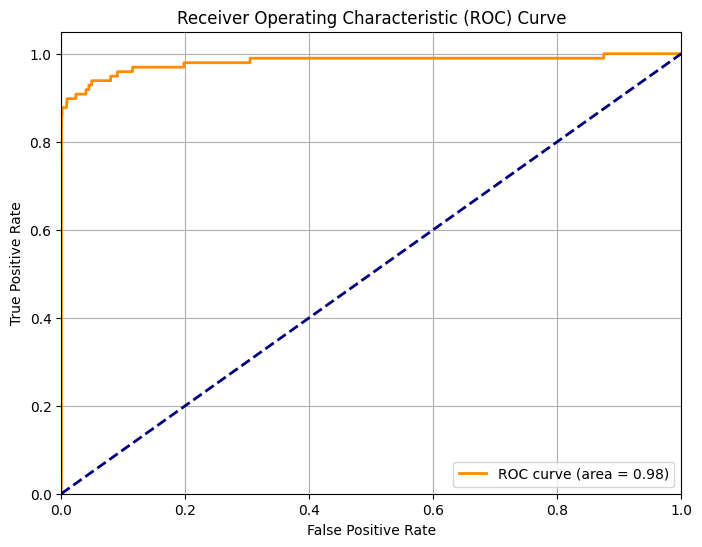

In [ ]:
# Generate ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, p_test)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Generate Precision-Recall curve

**Reasoning**:
Import `precision_recall_curve` and `average_precision_score` from `sklearn.metrics`. Calculate precision and recall values for different thresholds. Then, plot the Precision-Recall curve and display the average precision score.

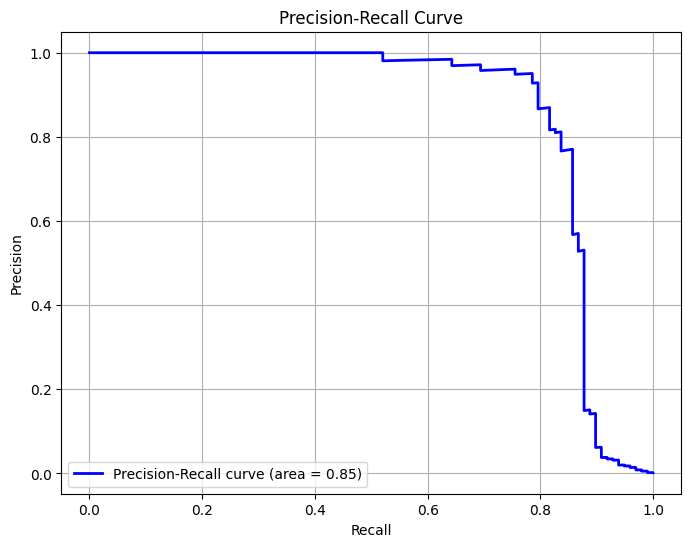

In [ ]:
# Generate Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Calculate precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test, p_test)

# Calculate the Average Precision Score (APS)
average_precision = average_precision_score(y_test, p_test)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

## Deployment Files

### Objective:
Generate the necessary files for deploying the trained model as a Flask web application.

## Deployment Files

### Objective:
Generate the necessary files for deploying the trained model as a Flask web application.

**Explanation**:
After training and evaluating the model, we will generate the files required to deploy this model as a web application using Flask. This includes saving the trained model, the scaler object, and the feature statistics. We will also create Python files for the Flask application (`app.py`) and a helper function for mapping user inputs (`mapper.py`), an HTML template for the web interface (`templates/index.html`), a `requirements.txt` file listing the necessary Python packages, and a `README.md` file with instructions for running and deploying the application. All these files will be saved to your specified Google Drive folder for easy access.

In [ ]:
# ---------- Save model bundle ----------
import joblib
model_bundle = {'model': best, 'scaler': scaler, 'demo_feature_stats': demo_feature_stats}
model_bundle_path = os.path.join(drive_output_dir, 'model_bundle.joblib')
joblib.dump(model_bundle, model_bundle_path)
print(f"Saved {model_bundle_path}")

# ---------- Write mapper.py (deterministic demo mapper) ----------
mapper_code = """
import numpy as np
import pandas as pd

def demo_mapper(user_input, demo_feature_stats):
    # user_input keys: amount, time_minutes, frequency_24h, transaction_type,
    # distance_km, device_loc_risk, merchant_type, hour_of_day
    t = float(user_input.get('time_minutes', 0.0)) * 60.0
    merchant_map = {'Grocery':0.0, 'Online Shopping':0.8, 'Travel':1.2, 'Electronics':0.5, 'Others':0.0}
    merchant_val = merchant_map.get(user_input.get('merchant_type','Others'), 0.0)
    amt = float(user_input.get('amount', 0.0))
    freq = float(user_input.get('frequency_24h', 0.0))
    hour = float(user_input.get('hour_of_day', 12.0))
    dlrisk = float(user_input.get('device_loc_risk', 0.0))
    distance = float(user_input.get('distance_km', 0.0))
    base = (amt / 100.0) + freq*0.3 + merchant_val + dlrisk*2.0 + distance/50.0 + (abs(12-hour)/12.0)
    V = []
    for i in range(1,29):
        stats = demo_feature_stats.get(f'V{i}', {'mean':0.0,'std':1.0})
        mean_i = stats['mean']
        std_i = stats['std'] if stats['std']>0 else 1.0
        val = mean_i + (np.sin(i + base) * (0.5 + (i%5)/5.0)) * std_i + ( (amt%100) / 100.0 - 0.5 ) * 0.2
        V.append(val)
    data = {'Time': [t], **{f'V{i}': [V[i-1]] for i in range(1,29)}, 'Amount': [amt]}
    df = pd.DataFrame(data)
    return df
"""
mapper_path = os.path.join(drive_output_dir, 'mapper.py')
with open(mapper_path,'w') as f:
    f.write(mapper_code)
print(f"Wrote {mapper_path}")

# ---------- Write Flask app ----------
app_code = r"""
from flask import Flask, render_template, request, send_file
import joblib, io, pandas as pd
from mapper import demo_mapper
import os # Import os

app = Flask(__name__)
# Define the path to the model bundle relative to where the app is run
# Assuming model_bundle.joblib is in the same directory as the app.py
model_bundle_path = os.path.join(os.path.dirname(__file__), 'model_bundle.joblib')
bundle = joblib.load(model_bundle_path) # Load from the relative path
model = bundle['model']
scaler = bundle['scaler']
demo_feature_stats = bundle.get('demo_feature_stats', {})

def predict_df(df):
    if 'Class' in df.columns:
        df = df.drop(columns=['Class'])
    expected = ['Time'] + [f'V{i}' for i in range(1,29)] + ['Amount']
    missing = [c for c in expected if c not in df.columns]
    if missing:
        return None, f"Missing columns: {missing}"
    df[['Time','Amount']] = scaler.transform(df[['Time','Amount']])
    probs = model.predict_proba(df[expected])[:,1]
    df_out = df.copy()
    df_out['fraud_prob'] = probs
    df_out['pred_class'] = (probs >= 0.6).astype(int)
    return df_out, None

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/upload', methods=['POST'])
def upload():
    f = request.files.get('file')
    df = pd.read_csv(f)
    df_out, err = predict_df(df)
    if err:
        return err, 400
    output = io.StringIO()
    df_out.to_csv(output, index=False)
    output.seek(0)
    return send_file(io.BytesIO(output.getvalue().encode()), as_attachment=True, download_name='predictions.csv', mimetype='text/csv')

@app.route('/predict_single', methods=['POST'])
def predict_single():
    trans_type = request.form.get('transaction_type','offline')
    amount = float(request.form.get('amount',0.0))
    time_min = float(request.form.get('time',0.0))
    frequency = int(request.form.get('frequency',0))
    merchant = request.form.get('merchant','Others')
    hour_of_day = int(request.form.get('hour',12))
    if trans_type == 'online':
        device_loc_risk = float(request.form.get('device_loc_risk',0.0))
        distance_km = 0.0
    else:
        device_loc_risk = 0.0
        distance_km = float(request.form.get('distance_km',0.0))
    user_input = {'amount': amount, 'time_minutes': time_min, 'frequency_24h': frequency,
                  'transaction_type': trans_type, 'distance_km': distance_km,
                  'device_loc_risk': device_loc_risk, 'merchant_type': merchant,
                  'hour_of_day': hour_of_day}
    df_demo = demo_mapper(user_input, demo_feature_stats)
    df_demo[['Time','Amount']] = scaler.transform(df_demo[['Time','Amount']])
    prob = float(model.predict_proba(df_demo[['Time'] + [f'V{i}' for i in range(1,29)] + ['Amount']])[0,1])
    label = "High Fraud Risk" if prob >= 0.6 else "Low Fraud Risk"
    advice = ""
    if prob >= 0.85:
        advice = "Block and contact bank."
    elif prob >= 0.6:
        advice = "Review and confirm."
    else:
        advice = "Looks normal."
    return render_template('index.html', result=label, probability=f"{prob*100:.2f}%", advice=advice, form_data=request.form)

if __name__ == "__main__":
    app.run(debug=True, host='0.0.0.0')
"""
app_path = os.path.join(drive_output_dir, 'app.py')
with open(app_path,'w') as f:
    f.write(app_code)
print(f"Wrote {app_path}")

# ---------- Write HTML template (templates/index.html) ----------
html_code = r"""
<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <title>Fraud Demo</title>
  <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.2/dist/css/bootstrap.min.css" rel="stylesheet">
  <script>
    function onTypeChange() {
      const t = document.querySelector('input[name="transaction_type"]:checked').value;
      document.getElementById('distance_group').style.display = t==='offline' ? 'block':'none';
      document.getElementById('device_group').style.display = t==='online' ? 'block':'none';
    }
    window.addEventListener('DOMContentLoaded', onTypeChange);
  </script>
</head>
<body class="bg-light">
<div class="container mt-4">
  <div class="card p-4">
    <h3>Credit Card Fraud Risk Predictor — Demo</h3>
    <form action="/predict_single" method="post">
      <div>Type:
        <label><input type="radio" name="transaction_type" value="offline" checked onchange="onTypeChange()">Offline</label>
        <label class="ms-2"><input type="radio" name="transaction_type" value="online" onchange="onTypeChange()">Online</label>
      </div>
      <div class="row mt-2">
        <div class="col-md-4"><label>Amount (₹)</label><input class="form-control" name="amount" required></div>
        <div class="col-md-4"><label>Time since last txn (minutes)</label><input class="form-control" name="time" required></div>
        <div class="col-md-4"><label>Hour (0-23)</label><input class="form-control" name="hour" value="12"></div>
        <div class="col-md-4"><label>Transactions in 24h</label><input class="form-control" name="frequency"></div>
        <div class="col-md-4" id="distance_group"><label>Distance km</label><input class="form-control" name="distance_km"></div>
        <div class="col-md-4" id="device_group" style="display:none"><label>Device/Location risk (0-1)</label><input class="form-control" name="device_loc_risk" value="0"></div>
        <div class="col-md-4"><label>Merchant</label><select class="form-control" name="merchant"><option>Grocery</option><option>Online Shopping</option><option>Travel</option><option>Electronics</option><option>Others</option></select></div>
      </div>
      <button class="btn btn-primary mt-3 w-100" type="submit">Check Risk</button>
    </form>

    {% if result %}
    <div class="alert mt-3 {{ 'alert-danger' if 'High' in result else 'alert-success' }}">
      <h4>{{ result }}</h4>
      <p>Probability: {{ probability }}</p>
      <p>{{ advice }}</p>
    </div>
    {% endif %}

    <hr>
    <h5>Bulk CSV upload (bank-format)</h5>
    <form action="/upload" method="post" enctype="multipart/form-data">
      <input type="file" name="file">
      <button class="btn btn-secondary mt-2">Upload</button>
    </form>
  </div>
</div>
</body>
</html>
"""
# Create templates directory in Drive output directory
templates_dir = os.path.join(drive_output_dir, 'templates')
os.makedirs(templates_dir, exist_ok=True)
html_path = os.path.join(templates_dir, 'index.html')
with open(html_path,'w') as f:
    f.write(html_code)
print(f"Wrote {html_path}")

# ---------- requirements.txt ----------
reqs = "flask\njoblib\npandas\nscikit-learn\nxgboost\nimbalanced-learn\nshap\n"
reqs_path = os.path.join(drive_output_dir, 'requirements.txt')
with open(reqs_path,'w') as f:
    f.write(reqs)
print(f"Wrote {reqs_path}")

# ---------- README.md ----------
readme = """
# Credit Card Fraud Detection — Demo

## Authors
- Chirag Nahata
- Snigdha Ghosh
- Somyadip Ghosh
- Surybha Pal

## Overview
Train XGBoost on Kaggle `creditcard.csv`. Provide Flask demo that supports single-user (online/offline) deterministic mapping and bulk CSV upload.

## Files
- model_bundle.joblib - saved model + scaler + demo stats
- mapper.py - deterministic demo mapper
- app.py - Flask app
- templates/index.html - UI template
- requirements.txt

## Run locally
1. Ensure you have the necessary files in the same directory.
2. python3 -m venv venv
3. source venv/bin/activate
4. pip install -r requirements.txt
5. python app.py
6. Open http://localhost:5000

## Deploy
Upload files to PythonAnywhere or similar. Ensure model_bundle.joblib, mapper.py, app.py, requirements.txt and the 'templates' folder (containing index.html) are in your project root directory.

## Notes
Demo mapping is synthetic and for presentation only.
"""
readme_path = os.path.join(drive_output_dir, 'README.md')
with open(readme_path,'w') as f:
    f.write(readme)
print(f"Wrote {readme_path}")

print(f"\nAll files written into {drive_output_dir} in your Google Drive.")

Saved /content/drive/MyDrive/Euphoria GenX Project (Credit Card Fraud Detection)/model_bundle.joblib
Wrote /content/drive/MyDrive/Euphoria GenX Project (Credit Card Fraud Detection)/mapper.py
Wrote /content/drive/MyDrive/Euphoria GenX Project (Credit Card Fraud Detection)/app.py
Wrote /content/drive/MyDrive/Euphoria GenX Project (Credit Card Fraud Detection)/templates/index.html
Wrote /content/drive/MyDrive/Euphoria GenX Project (Credit Card Fraud Detection)/requirements.txt
Wrote /content/drive/MyDrive/Euphoria GenX Project (Credit Card Fraud Detection)/README.md

All files written into /content/drive/MyDrive/Euphoria GenX Project (Credit Card Fraud Detection) in your Google Drive.
